# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to build and evaluate a __predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use a simple model such as Logistic Regression for this task or try one of the more advanced methods covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

__Approach__
- Clean data, deal with outliers, normalise data
- Check for collinearity (pairplot)
- RFE or other methods
- model

#### Read data and remove RECON columns, CUST_ID

In [2]:
churn = pd.read_csv("files/MobileCustomerChurn.csv", na_values=["NA", "#VALUE!"], index_col='INDEX')
churn = churn.iloc[:, :-3] #remove last 3 RECON columns
churn = churn.iloc[:,1:] #remove customer ID
churn.head()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE
INDEX,,,,,,,,,,,,,,,,,
1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,24,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA
2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,24,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW
3,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,12,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA
4,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,24,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC
5,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,24,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW


#### Examine data

In [25]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46206 entries, 1 to 46206
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ACCOUNT_TENURE                46206 non-null  int64  
 1   ACCT_CNT_SERVICES             46206 non-null  int64  
 2   AGE                           46130 non-null  float64
 3   CFU                           46206 non-null  object 
 4   SERVICE_TENURE                46206 non-null  int64  
 5   PLAN_ACCESS_FEE               46206 non-null  float64
 6   BYO_PLAN_STATUS               46206 non-null  object 
 7   PLAN_TENURE                   46206 non-null  int64  
 8   MONTHS_OF_CONTRACT_REMAINING  46206 non-null  int64  
 9   LAST_FX_CONTRACT_DURATION     46206 non-null  int64  
 10  CONTRACT_STATUS               46206 non-null  object 
 11  PREV_CONTRACT_DURATION        46206 non-null  int64  
 12  HANDSET_USED_BRAND            46206 non-null  object 
 13  C

In [78]:
for col in churn:
    print(col, churn[col].unique())
    print('-'*60)

ACCOUNT_TENURE [ 46  60  65  31  95  62  90  12  13   9  47  24  49  75  33  10  25   4
  34  67  92  76  45  73  85  32  16   3  58  96  91  78  50  57  93  83
  30  94   8   7  23  89  80  27   0  97  63   6  69  64  87  54   1  51
  11  19  41  22  79  43  14   5  21   2  15  20  66  38  28  86  53  40
  71  84  42  55  48  81  36  26  39  88  44  61  17  59  82  99  29  98
  18  74  37  35  52  70  56  68  77  72 103 114 105 111 100 108 102 109
 107 110 104 116 101 119 112 115 106 118 113 120 117]
------------------------------------------------------------
ACCT_CNT_SERVICES [1 3 2 4]
------------------------------------------------------------
AGE [ 30.  55.  29.  51.  31.  25.  35.  66.  21.  41.  59.  22.  53.  47.
  50.  20.  48.  49.  26.  34.  68.  27.  56.  43.  44.  18.  60.  61.
  58.  23.  65.  33.  24.  45.  39.  64.  40.  19.  42.  52.  57.  54.
  46.  71.  32.  88.  79.  36.  72.  28.  62.  85.  70.  nan  69.  38.
  37.  77.  75.  63.  76.  73.  86.  16.  67.  89.  84.

In [27]:
churn.isna().sum()

ACCOUNT_TENURE                   0
ACCT_CNT_SERVICES                0
AGE                             76
CFU                              0
SERVICE_TENURE                   0
PLAN_ACCESS_FEE                  0
BYO_PLAN_STATUS                  0
PLAN_TENURE                      0
MONTHS_OF_CONTRACT_REMAINING     0
LAST_FX_CONTRACT_DURATION        0
CONTRACT_STATUS                  0
PREV_CONTRACT_DURATION           0
HANDSET_USED_BRAND               0
CHURN_IND                        0
MONTHLY_SPEND                    0
COUNTRY_METRO_REGION             1
STATE                            1
dtype: int64

In [28]:
churn.loc[churn.AGE.isna()]

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE
INDEX,,,,,,,,,,,,,,,,,
186,94,2,NaN,SMALL BUSINESS,94,45.44,NON BYO,27,0,24,OFF-CONTRACT,24,HUAWEI,1,51.79,COUNTRY,NSW
213,39,4,NaN,SMALL BUSINESS,1,36.36,NON BYO,1,0,0,NO-CONTRACT,0,SAMSUNG,1,48.37,METRO,NSW
2047,4,2,NaN,SMALL BUSINESS,4,72.72,NON BYO,4,20,24,ON-CONTRACT,0,SAMSUNG,1,72.72,METRO,ACT
2560,8,4,NaN,SMALL BUSINESS,8,27.27,BYO,5,0,0,NO-CONTRACT,0,APPLE,1,37.66,METRO,VIC
4129,9,3,NaN,SMALL BUSINESS,9,72.72,NON BYO,9,15,24,ON-CONTRACT,0,APPLE,1,72.72,METRO,NSW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41919,7,3,NaN,SMALL BUSINESS,5,27.27,BYO,5,0,0,NO-CONTRACT,0,SAMSUNG,1,72.56,METRO,VIC
42252,94,2,NaN,SMALL BUSINESS,16,54.54,NON BYO,0,24,24,ON-CONTRACT,0,APPLE,0,91.35,METRO,VIC
44004,0,1,NaN,SMALL BUSINESS,0,45.45,NON BYO,0,0,0,NO-CONTRACT,0,APPLE,0,45.45,METRO,WA


## Clean the data

In [3]:
churn_dummy = pd.get_dummies(churn)
churn_dummy.head()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,...,COUNTRY_METRO_REGION_COUNTRY,COUNTRY_METRO_REGION_METRO,STATE_ACT,STATE_NSW,STATE_NT,STATE_QLD,STATE_SA,STATE_TAS,STATE_VIC,STATE_WA
INDEX,,,,,,,,,,,,,,,,,,,,,
1,46,1,30.0,46,54.54,15,0,24,24,1,...,1,0,0,0,0,0,0,0,0,1
2,60,3,55.0,59,54.54,5,0,24,24,1,...,0,1,0,1,0,0,0,0,0,0
3,65,1,29.0,65,40.90,15,0,12,12,1,...,1,0,0,0,0,0,0,0,0,1
4,31,1,51.0,31,31.81,31,0,24,24,1,...,1,0,0,0,0,0,0,0,1,0
5,95,1,31.0,95,54.54,0,0,24,24,1,...,0,1,0,1,0,0,0,0,0,0


In [29]:
with pd.option_context('display.max_columns', None): #force to display all data
    print(pd.get_dummies(churn))

       ACCOUNT_TENURE  ACCT_CNT_SERVICES   AGE  SERVICE_TENURE  \
INDEX                                                            
1                  46                  1  30.0              46   
2                  60                  3  55.0              59   
3                  65                  1  29.0              65   
4                  31                  1  51.0              31   
5                  95                  1  31.0              95   
...               ...                ...   ...             ...   
46202              10                  1  61.0               9   
46203               2                  1  53.0               2   
46204              47                  1  22.0              47   
46205              94                  1  40.0             182   
46206               0                  1  24.0               0   

       PLAN_ACCESS_FEE  PLAN_TENURE  MONTHS_OF_CONTRACT_REMAINING  \
INDEX                                                               
1  

In [31]:
churn_dummy.isna().sum()

ACCOUNT_TENURE                   0
ACCT_CNT_SERVICES                0
AGE                             76
SERVICE_TENURE                   0
PLAN_ACCESS_FEE                  0
PLAN_TENURE                      0
MONTHS_OF_CONTRACT_REMAINING     0
LAST_FX_CONTRACT_DURATION        0
PREV_CONTRACT_DURATION           0
CHURN_IND                        0
MONTHLY_SPEND                    0
CFU_CONSUMER                     0
CFU_SMALL BUSINESS               0
BYO_PLAN_STATUS_BYO              0
BYO_PLAN_STATUS_NON BYO          0
CONTRACT_STATUS_NO-CONTRACT      0
CONTRACT_STATUS_OFF-CONTRACT     0
CONTRACT_STATUS_ON-CONTRACT      0
HANDSET_USED_BRAND_APPLE         0
HANDSET_USED_BRAND_GOOGLE        0
HANDSET_USED_BRAND_HUAWEI        0
HANDSET_USED_BRAND_OTHER         0
HANDSET_USED_BRAND_SAMSUNG       0
HANDSET_USED_BRAND_UNKNOWN       0
COUNTRY_METRO_REGION_COUNTRY     0
COUNTRY_METRO_REGION_METRO       0
STATE_ACT                        0
STATE_NSW                        0
STATE_NT            

In [4]:
# Remove NAs
churn_dummy.dropna(inplace=True) 
churn_dummy.isna().sum() 

ACCOUNT_TENURE                  0
ACCT_CNT_SERVICES               0
AGE                             0
SERVICE_TENURE                  0
PLAN_ACCESS_FEE                 0
PLAN_TENURE                     0
MONTHS_OF_CONTRACT_REMAINING    0
LAST_FX_CONTRACT_DURATION       0
PREV_CONTRACT_DURATION          0
CHURN_IND                       0
MONTHLY_SPEND                   0
CFU_CONSUMER                    0
CFU_SMALL BUSINESS              0
BYO_PLAN_STATUS_BYO             0
BYO_PLAN_STATUS_NON BYO         0
CONTRACT_STATUS_NO-CONTRACT     0
CONTRACT_STATUS_OFF-CONTRACT    0
CONTRACT_STATUS_ON-CONTRACT     0
HANDSET_USED_BRAND_APPLE        0
HANDSET_USED_BRAND_GOOGLE       0
HANDSET_USED_BRAND_HUAWEI       0
HANDSET_USED_BRAND_OTHER        0
HANDSET_USED_BRAND_SAMSUNG      0
HANDSET_USED_BRAND_UNKNOWN      0
COUNTRY_METRO_REGION_COUNTRY    0
COUNTRY_METRO_REGION_METRO      0
STATE_ACT                       0
STATE_NSW                       0
STATE_NT                        0
STATE_QLD     

## Explore Data

Text(0.5, 1.0, 'Data Range')

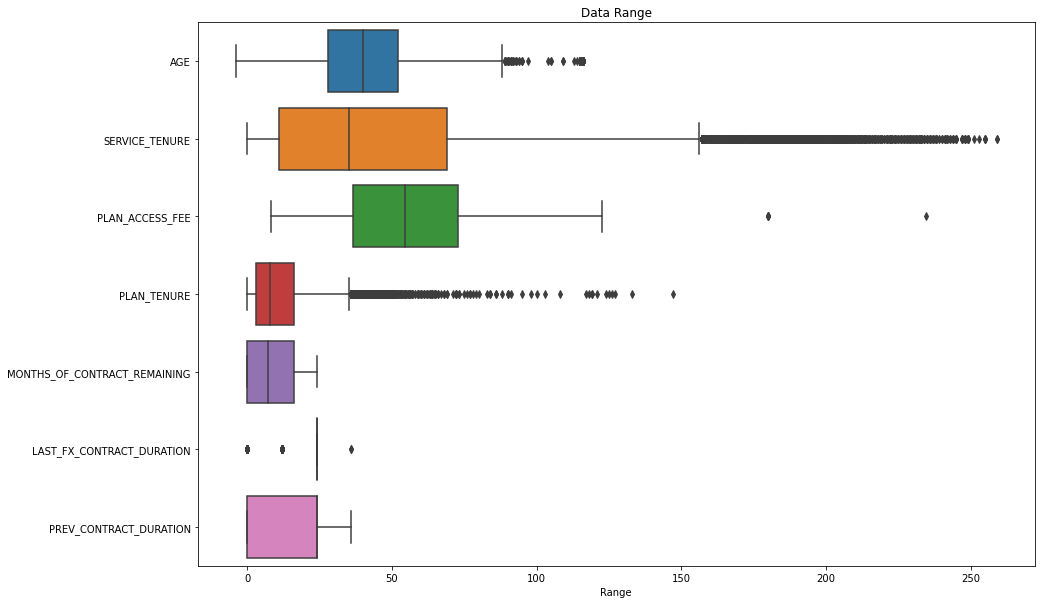

In [194]:
plt.figure(figsize=(15,10))
sns.boxplot(data=churn_dummy.iloc[:,1:8],orient='h')
plt.xlabel('Range')
plt.title('Data Range')

<AxesSubplot:>

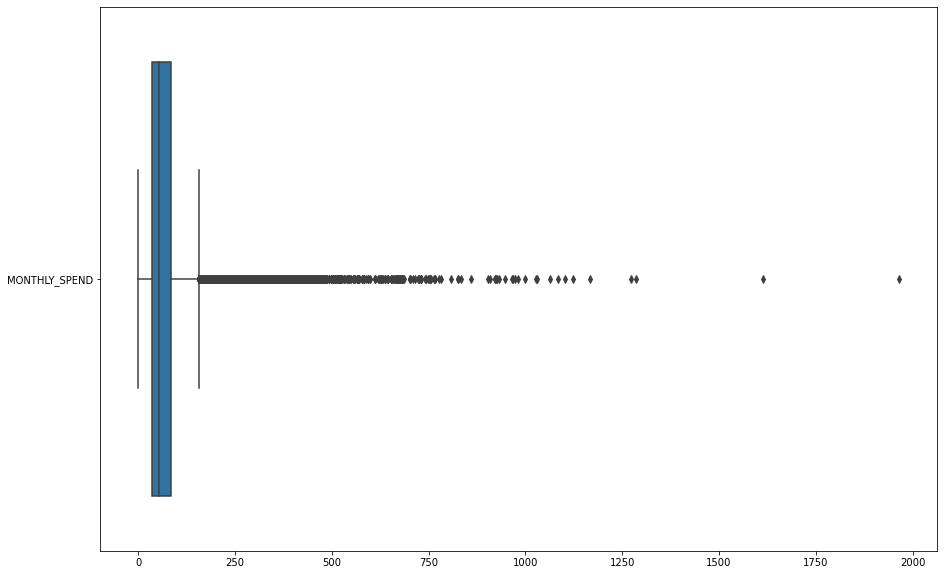

In [191]:
plt.figure(figsize=(15,10))
sns.boxplot(data=churn.iloc[:,14:15],orient='h')

The real outliers may be:
- Plan access fees more than \$160
- Monthly spend more than \$1500

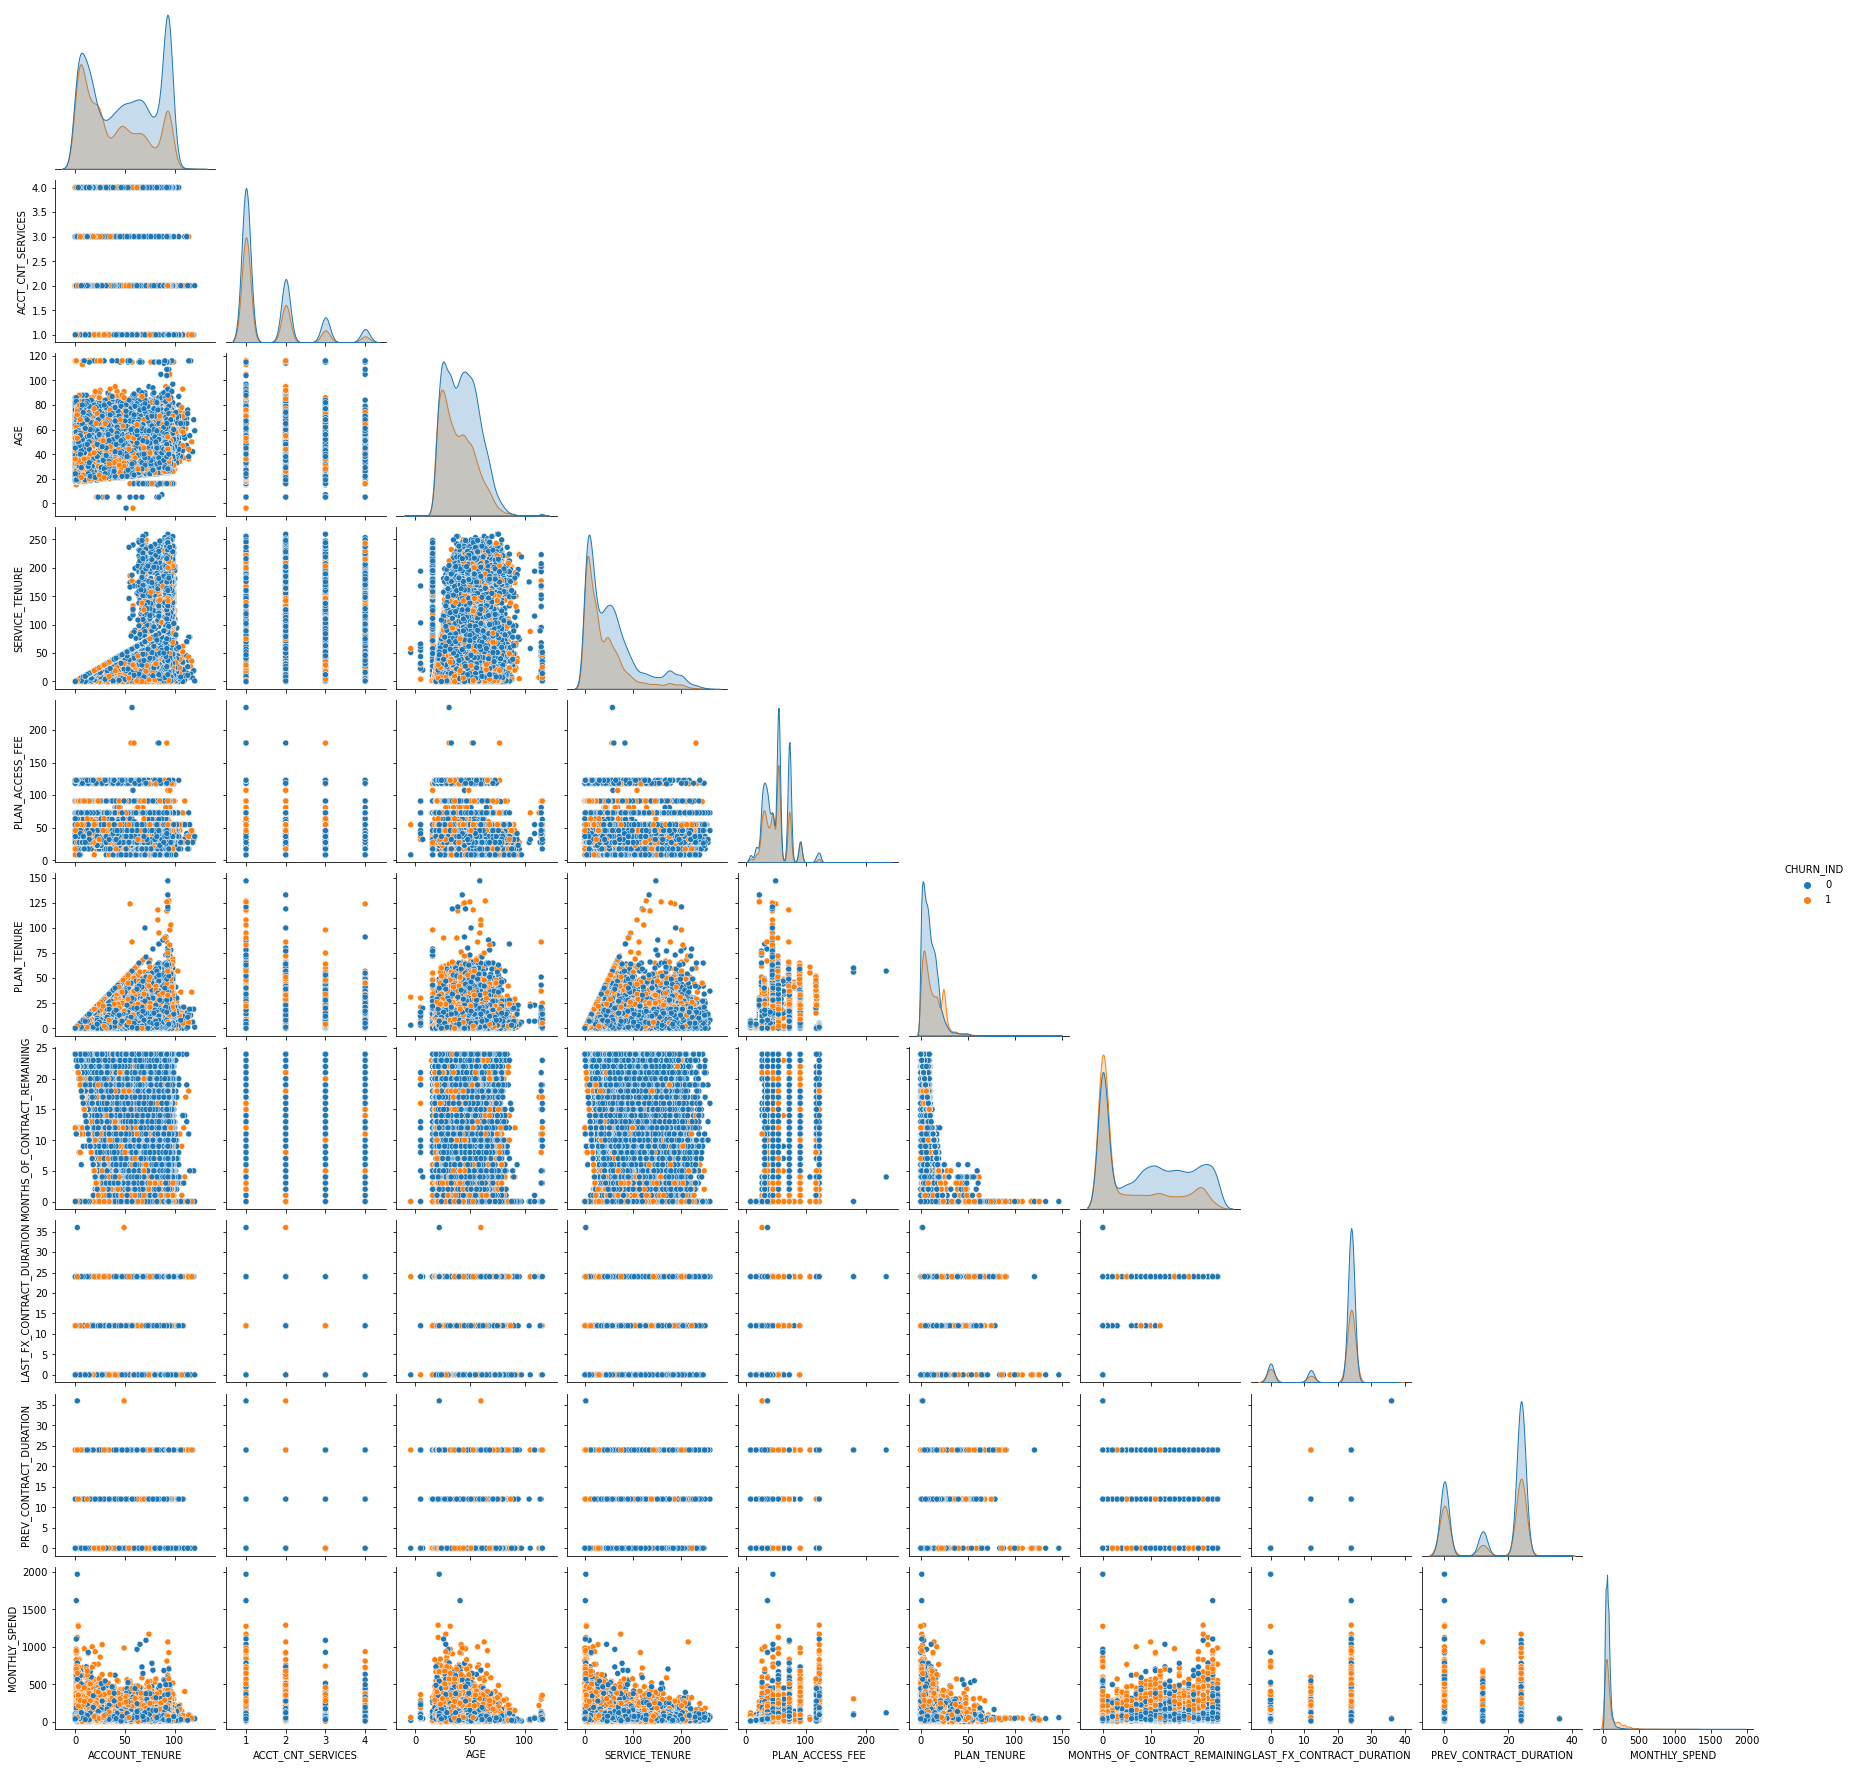

In [83]:
sns.pairplot(churn,hue='CHURN_IND',corner=True)

Text(0.5, 1.0, 'Correlation matrix')

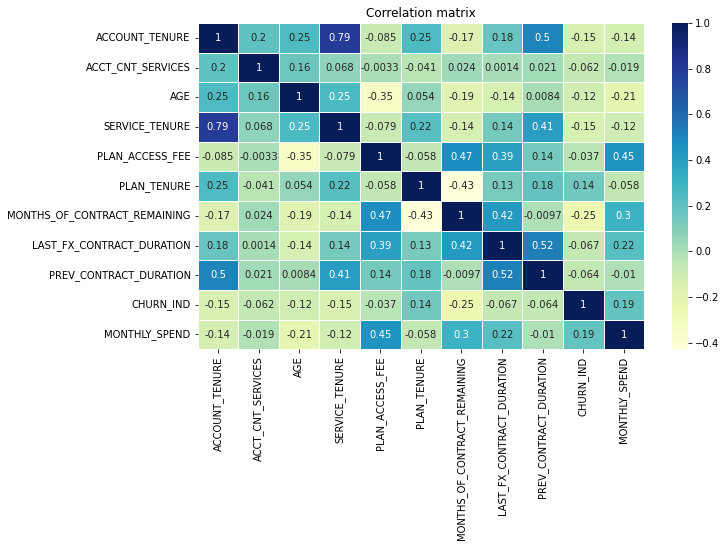

In [90]:
plt.figure(figsize=(10,6))
sns.heatmap(churn.corr(),linewidth=.5,annot=True,cmap='YlGnBu')
plt.title('Correlation matrix')

.79 is high. The model experiences multi-collinearity with these 2 variables and we need to drop one.

__Examine Service Tenure and Account Tenure in each state__

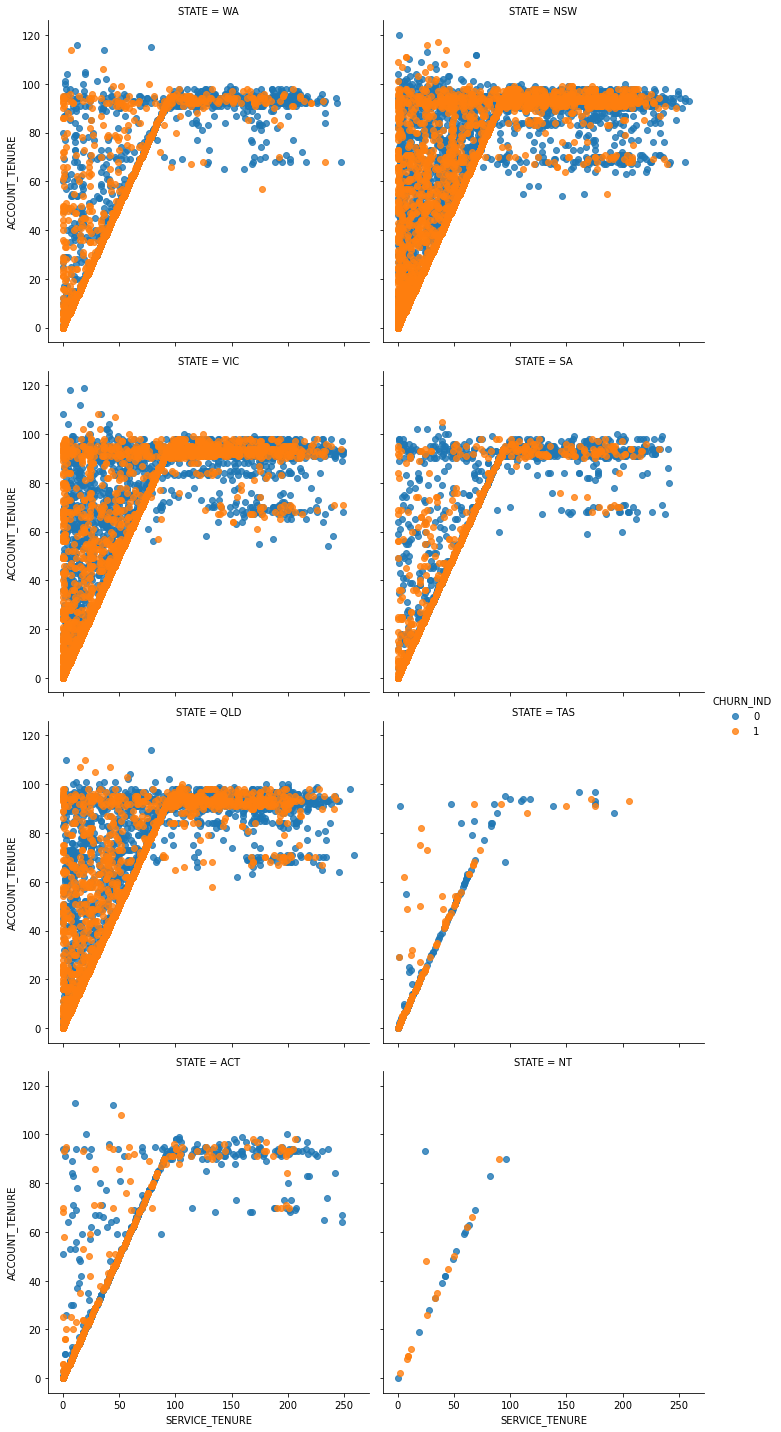

In [104]:
sns.lmplot(data=churn, x='SERVICE_TENURE', y='ACCOUNT_TENURE', hue='CHURN_IND', fit_reg=False, 
           col='STATE', col_wrap=2)

Service tenure is measured in months and is easier to interpret, compared to account tenure which is measured from the last day of the reporting month.

__Drop Account tenure__

In [107]:
churn_dummy.drop('ACCOUNT_TENURE',axis=1,inplace=True)

In [192]:
churn_dummy.head(1)

,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND,...,COUNTRY_METRO_REGION_COUNTRY,COUNTRY_METRO_REGION_METRO,STATE_ACT,STATE_NSW,STATE_NT,STATE_QLD,STATE_SA,STATE_TAS,STATE_VIC,STATE_WA
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,30.0,46,54.54,15,0,24,24,1,61.4,...,1,0,0,0,0,0,0,0,0,1


__Examine other variables__

In [196]:
print('Examine distribution of:')
high_range = churn_dummy[churn_dummy > 10].notna().sum()>10
high_range = list(high_range[high_range==True].index)
high_range

Examine distribution of:


['AGE',
 'SERVICE_TENURE',
 'PLAN_ACCESS_FEE',
 'PLAN_TENURE',
 'MONTHS_OF_CONTRACT_REMAINING',
 'LAST_FX_CONTRACT_DURATION',
 'PREV_CONTRACT_DURATION',
 'MONTHLY_SPEND']

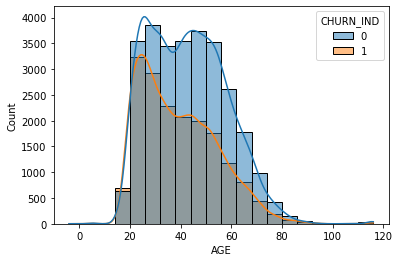

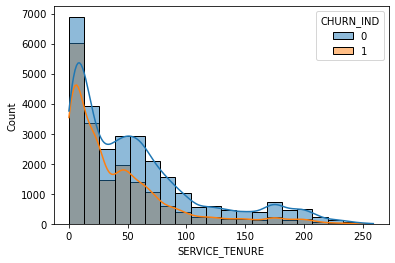

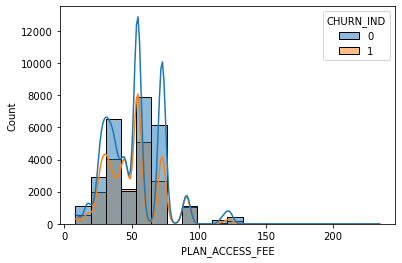

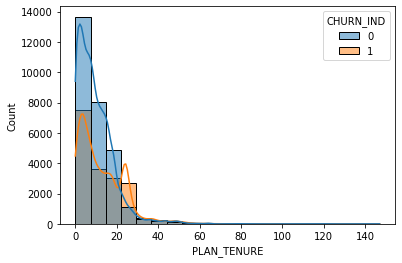

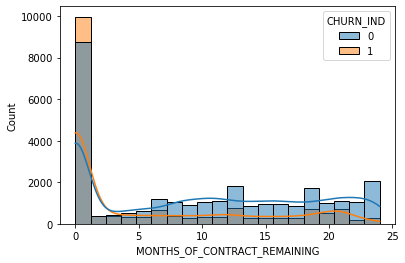

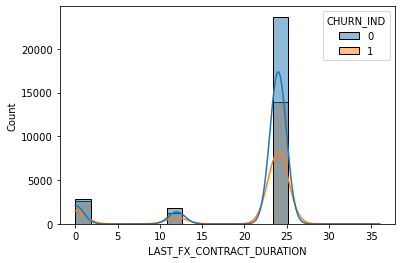

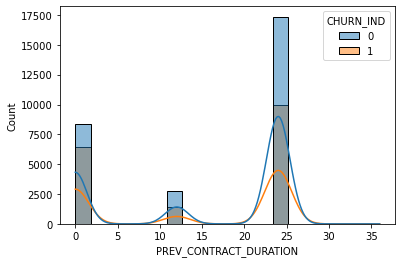

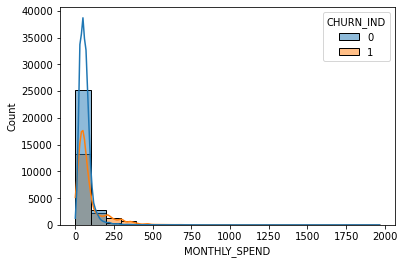

In [197]:
for i in high_range:
    plt.figure(i)
    sns.histplot(data=churn, x=i,kde=True,bins=20,hue='CHURN_IND',alpha=.5)

A lot of the data are not normal and vary a lot. It may make sense to normalise these before making a model. However, we'll compare the results with and without normalising the data.

In [12]:
ax_corr.containers[0]

<BarContainer object of 34 artists>

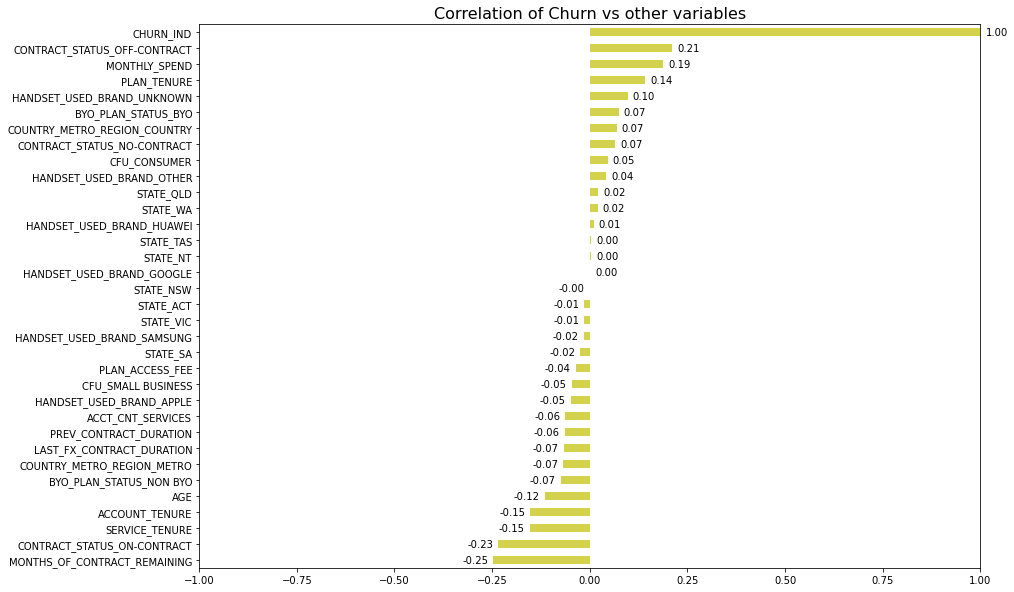

In [33]:
plt.figure(figsize=(14,10))
ax_corr = churn_dummy.corr()['CHURN_IND'].sort_values().plot(kind='barh',color='y',alpha=.7)
plt.title('Correlation of Churn vs other variables',fontsize=16)
ax_corr.bar_label(ax_corr.containers[0],fmt='%.2f', padding = 5)
plt.xlim(-1,1)
plt.show()

Among the least correlated with Churn are the Australian states and handset brand used. As these values are close to 0, we may need to exclude these from the model.

Another approach might be to remove correlations with +-0.05

## Modeling

In [251]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.feature_selection import RFE

# Data Scaling
from sklearn.preprocessing import MinMaxScaler

# Models
from sklearn.linear_model import LogisticRegression

In [202]:
df = churn_dummy.copy(deep=True)
df.head()

,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND,...,COUNTRY_METRO_REGION_COUNTRY,COUNTRY_METRO_REGION_METRO,STATE_ACT,STATE_NSW,STATE_NT,STATE_QLD,STATE_SA,STATE_TAS,STATE_VIC,STATE_WA
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,30.0,46,54.54,15,0,24,24,1,61.40,...,1,0,0,0,0,0,0,0,0,1
2,3,55.0,59,54.54,5,0,24,24,1,54.54,...,0,1,0,1,0,0,0,0,0,0
3,1,29.0,65,40.90,15,0,12,12,1,2.50,...,1,0,0,0,0,0,0,0,0,1
4,1,51.0,31,31.81,31,0,24,24,1,6.48,...,1,0,0,0,0,0,0,0,1,0
5,1,31.0,95,54.54,0,0,24,24,1,100.22,...,0,1,0,1,0,0,0,0,0,0


In [ ]:
# features = list(df.columns[0:8]) + list(df.columns[9:])

### Logistic Regression

#### Base Model
MinMaxScale normalisation, no hyperparameter tuning, no feature selection

In [260]:
X = df.drop('CHURN_IND',axis=1)
y = df['CHURN_IND']

# Scale data to [0,1]
features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X)) # turns columns into numbers
X.columns = features # bring back column names

In [262]:
# Split 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=100)

# Logistic Regression Model
logreg = LogisticRegression()
result = logreg.fit(X_train, y_train)

In [263]:
print(X_train.shape)
print(X_test.shape)

(36904, 32)
(9226, 32)


In [265]:
prediction_test = logreg.predict(X_test)

# Prediction accuracy
print('Prediction accuracy:',accuracy_score(y_test, prediction_test))

Prediction accuracy: 0.7256665944071103


In [267]:
pd.Series(logreg.coef_[0],index=X.columns.values)

ACCT_CNT_SERVICES               -0.114521
AGE                             -2.080669
SERVICE_TENURE                  -2.084294
PLAN_ACCESS_FEE                 -0.708029
PLAN_TENURE                      0.939364
MONTHS_OF_CONTRACT_REMAINING    -1.941956
LAST_FX_CONTRACT_DURATION        0.550326
PREV_CONTRACT_DURATION          -0.600394
MONTHLY_SPEND                   18.339789
CFU_CONSUMER                     0.186141
CFU_SMALL BUSINESS               0.050404
BYO_PLAN_STATUS_BYO             -0.266198
BYO_PLAN_STATUS_NON BYO          0.502743
CONTRACT_STATUS_NO-CONTRACT      0.280820
CONTRACT_STATUS_OFF-CONTRACT     0.597813
CONTRACT_STATUS_ON-CONTRACT     -0.642088
HANDSET_USED_BRAND_APPLE        -0.243359
HANDSET_USED_BRAND_GOOGLE       -0.185787
HANDSET_USED_BRAND_HUAWEI       -0.091026
HANDSET_USED_BRAND_OTHER         0.176619
HANDSET_USED_BRAND_SAMSUNG      -0.084291
HANDSET_USED_BRAND_UNKNOWN       0.664390
COUNTRY_METRO_REGION_COUNTRY     0.271823
COUNTRY_METRO_REGION_METRO      -0

##### RFE